In [1]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from src.model.beta_vae import BetaVAE
from src.model.decoder import Decoder
from src.model.info_discriminator import InfoDiscriminator
from src.model.vector_quantizer import VectorQuantizer
from src.utils.common import instantiate_layer

In [2]:
device = torch.device('cpu')

## Model Loading Functions

In [3]:
def load_beta_vae(exp_dir, model_name="latest.pt", device=torch.device("cpu")):
  modelpath = os.path.join(exp_dir, model_name)
  configpath = os.path.join(exp_dir, "config.json")

  ## load config
  with open(configpath) as f:
    config = json.load(f)
  
  ## construct model
  model = BetaVAE(
    config["beta"],
    config["enc_model_args"],
    config["dec_linear_model_args"],
    config["dec_spatial_model_args"],
    config["dec_linear_to_spatial_shape"],
    device
  ).to(device)

  ## load model checkpoint
  chkpt = torch.load(modelpath, map_location=device)
  model.load_state_dict(chkpt["model"])

  return model

In [4]:
def load_info_gan(exp_dir, data, model_name="latest.pt", device=torch.device("cpu")):
  modelpath = os.path.join(exp_dir, model_name)
  configpath = os.path.join(exp_dir, "config.json")

  ## load config
  with open(configpath) as f:
    config = json.load(f)
  
  ## construct model
  generator = Decoder(
    config["gen_linear_model_args"],
    config["gen_linear_to_spatial_shape"],
    config["gen_spatial_model_args"]
  ).to(device)

  discriminator = InfoDiscriminator(
    config["disc_model_args"],
    data, device
  ).to(device)

  ## load model checkpoint
  chkpt = torch.load(modelpath, map_location=device)
  generator.load_state_dict(chkpt["generator"])
  discriminator.load_state_dict(chkpt["discriminator"])

  return generator, discriminator

In [5]:
def load_vq_vae(exp_dir, model_name="latest.pt", device=torch.device("cpu")):
  modelpath = os.path.join(exp_dir, model_name)
  configpath = os.path.join(exp_dir, "config.json")

  ## load config
  with open(configpath) as f:
    config = json.load(f)
  
  ## construct model
  encoder = nn.Sequential(*[
    instantiate_layer(lt, lp) for lt, lp in config["enc_model_args"]]).to(device)
  decoder = nn.Sequential(*[
    instantiate_layer(lt, lp) for lt, lp in config["dec_model_args"]]).to(device)
  vqlayer = VectorQuantizer(
    config["num_embedding"],
    config["embedding_dim"],
    config["beta"]).to(device)

  ## load model checkpoint
  chkpt = torch.load(modelpath, map_location=device)
  encoder.load_state_dict(chkpt["encoder"])
  decoder.load_state_dict(chkpt["decoder"])
  vqlayer.load_state_dict(chkpt["vqlayer"])

  return encoder, decoder, vqlayer

## Data Loading Function

In [6]:
def load_dataset(data, is_data_train, is_prob_value=True):
  """
  args
    data: either `mnist`, `celeba`, or `cifar10`.
    is_data_train: whether to load the training set or the testing set.
    is_prob_value: whether pixel value is (0, 1) [True] or (-1, 1) [False].
  """
  if data == "mnist":
    ## transformations
    tf = [transforms.ToTensor()]
    if not is_prob_value: tf += [transforms.Normalize((0.5,), (0.5,))]
    tf = transforms.Compose(tf)

    ## load dataset
    ds = datasets.MNIST("data", train=is_data_train, download=True, transform=tf)

  elif data == "celeba":
    ## transformations
    tf = [
      transforms.CenterCrop(178),
      transforms.Resize(128),
      transforms.ToTensor()
    ]
    if not is_prob_value: tf += [transforms.Normalize((0.5,), (0.5,))]
    tf = transforms.Compose(tf)

    ## load dataset
    ## no distinction between whether `is_data_train` is True or False
    ds = datasets.ImageFolder("data/celeba", transform=tf)
  
  elif data == "cifar10":
    ## transformations
    tf = [transforms.ToTensor()]
    if not is_prob_value: tf += [transforms.Normalize((0.5,), (0.5,))]
    tf = transforms.Compose(tf)

    ## load dataset
    ds = datasets.CIFAR10("data", train=is_data_train, download=True, transform=tf)
  
  return ds

## Plotting Function

In [7]:
def plot_column_wise(list_of_imgs, col_titles, filename, cmap):
  ## prepare figure
  n_row, n_col = list_of_imgs[0].shape[0], len(list_of_imgs)
  f, axs = plt.subplots(n_row, n_col, figsize=(n_col*3, n_row*4))

  ## plot in a column format
  for col, (imgs_set, title) in enumerate(zip(list_of_imgs, col_titles)):
    axs[0, col].set_title(title)

    for row in range(imgs_set.shape[0]):
      axs[row, col].imshow(imgs_set[row], cmap=cmap)
      axs[row, col].axis('off')

  f.savefig(filename)

def plot_row_wise(list_of_imgs, row_titles, filename, cmap):
  ## prepare figure
  n_row, n_col = len(list_of_imgs), list_of_imgs[0].shape[0]
  f, axs = plt.subplots(n_row, n_col, figsize=(n_col*3, n_row*4))

  ## plot in a row format
  for row, (imgs_set, title) in enumerate(zip(list_of_imgs, row_titles)):
    axs[row, n_col//2].set_title(title)

    for col in range(imgs_set.shape[0]):
      axs[row, col].imshow(imgs_set[col], cmap=cmap)
      axs[row, col].axis('off')
  
  f.savefig(filename)

## Plot Reconstruction (across different `beta` values)

In [ ]:
## -------- MNIST --------

exp_dirs, cmap = [
  "experiment/beta-vae/mnist5",
  "experiment/beta-vae/mnist4",
  "experiment/beta-vae/mnist0",
  "experiment/beta-vae/mnist1",
  "experiment/beta-vae/mnist2",
  "experiment/beta-vae/mnist3"
], 'gray'

col_titles = ["beta=0.1", "beta=0.5", "beta=1", "beta=4", "beta=10", "beta=20", "original"]

## load MNIST data and carefully picked index
ds = load_dataset("mnist", is_data_train=True, is_prob_value=True)
idx = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

## prepare the image
imgs = torch.cat([ds[i][0].unsqueeze(0) for i in idx]).to(device)
recon_imgs = []

for dir in exp_dirs:
  ## load model
  model = load_beta_vae(dir, "best.pt", device)

  ## reconstruct input
  var_posterior = model.encoder(imgs)
  recon = model.decoder(var_posterior.mean)

  ## save to `recon_imgs`` using renderable format
  recon_imgs.append(recon.squeeze(1).detach().cpu().numpy())

## convert `imgs` to renderable format
imgs = imgs.squeeze(1).detach().cpu().numpy()
recon_imgs.append(imgs)

## plot and save
filename = "figures/beta_vae-mnist-best_model-reconstruct_vary_beta.png"
plot_column_wise(recon_imgs, col_titles, filename, cmap)

In [ ]:
## -------- CELEBA --------

exp_dirs, cmap = [
  "experiment/beta-vae/celeba5",
  "experiment/beta-vae/celeba4",
  "experiment/beta-vae/celeba0",
  "experiment/beta-vae/celeba1",
  "experiment/beta-vae/celeba2",
  "experiment/beta-vae/celeba3"
], None

col_titles = ["beta=0.1", "beta=0.5", "beta=1", "beta=4", "beta=10", "beta=20", "original"]

## load MNIST data and carefully picked index
ds = load_dataset("celeba", is_data_train=True, is_prob_value=True)
idx = list(range(len(ds)))

## prepare the image
imgs = torch.cat([ds[i][0].unsqueeze(0) for i in idx]).to(device)
recon_imgs = []

for dir in exp_dirs:
  ## load model
  model = load_beta_vae(dir, "latest.pt", device)

  ## reconstruct input
  var_posterior = model.encoder(imgs)
  recon = model.decoder(var_posterior.mean)

  ## save to `recon_imgs`` using renderable format
  recon_imgs.append(recon.moveaxis(1, -1).detach().cpu().numpy())

## convert `imgs` to renderable format
imgs = imgs.moveaxis(1, -1).detach().cpu().numpy()
recon_imgs.append(imgs)

## plot and save
filename = "figures/beta_vae-celeba-latest_model-reconstruct_vary_beta.png"
plot_column_wise(recon_imgs, col_titles, filename, cmap)

## Plot Traverse Latent (Beta-VAE)

In [ ]:
data_name = "celeba"
data_idx = "5"
beta_name = "beta_0.1"
model_name = "latest"

dir, cmap = "experiment/beta-vae/" + data_name + data_idx, "gray"

## load model
model = load_beta_vae(dir, model_name + ".pt", device)
latent_size = model.prior.event_shape[0]
latent_diff = torch.tensor([-2.5, -2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5])

gen_imgs = []
for i in range(latent_size):
  ## prepare the interpolated latent
  latent = torch.zeros(latent_diff.shape[0], latent_size, device=device)
  latent[:, i] = latent_diff

  ## generated image
  gen_img = model.decoder(latent)

  ## convert to renderable format and save
  if data_name == "mnist":
    gen_imgs.append(gen_img.squeeze(1).detach().cpu().numpy())
  elif data_name == "celeba":
    gen_imgs.append(gen_img.moveaxis(1, -1).detach().cpu().numpy())

## plot and save
filename = "figures/beta_vae-" + data_name + "-" + model_name + "_model-" + beta_name + "-interpolate.png"
plot_row_wise(gen_imgs, list(range(len(gen_imgs))), filename, cmap)

## Plot Traverse Latent (InfoGAN)

In [69]:
def to_flatten_categorical(x, num_category, device):
  batch_size, code_size = x.shape
  
  ## idx to flip the values to 1.
  batch_idx = np.repeat(list(range(batch_size)), code_size)
  code_idx = list(range(code_size)) * batch_size
  data_idx = x.flatten()
  
  ## categorical data
  cat = torch.zeros(batch_size, code_size, num_category, device=device)
  cat[batch_idx, code_idx, data_idx] = 1.
  
  return cat.reshape(-1, code_size * num_category)

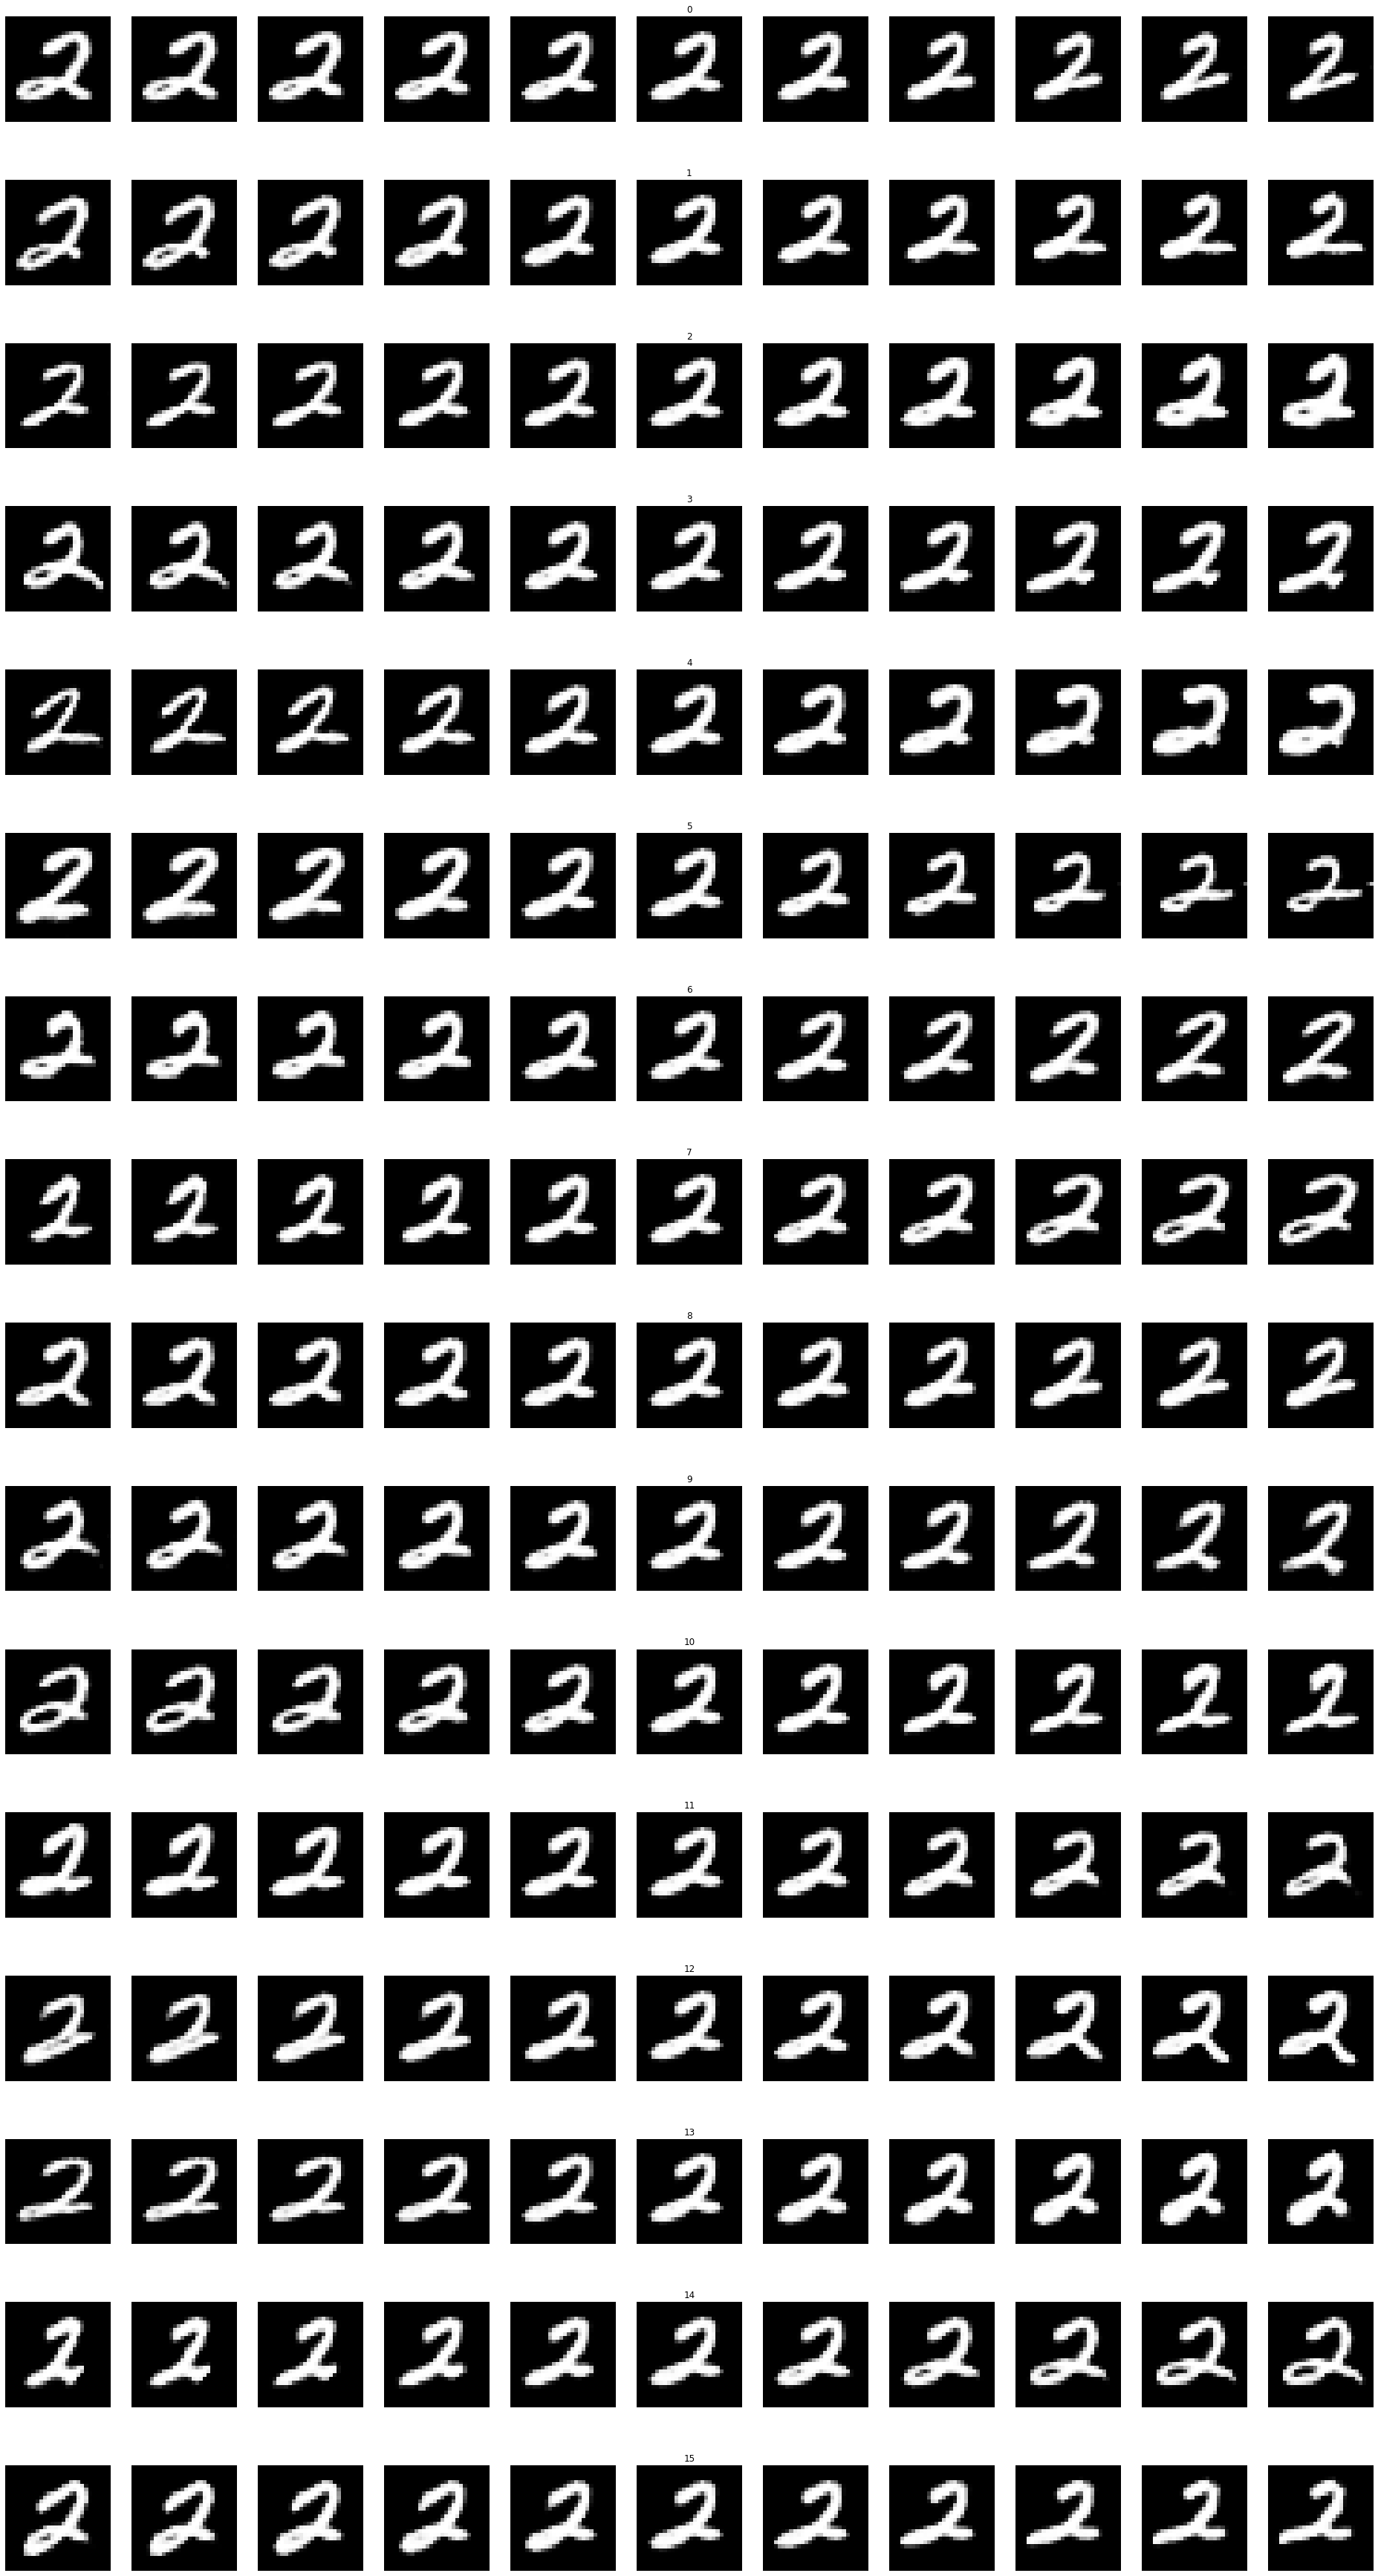

In [90]:
## -------- TRAVERSE NOISE --------

data_name = "mnist"
model_name = "latest"
cmap = "gray"
dir = "experiment/info-gan/" + data_name + "0"

## load model
generator, _ = load_info_gan(dir, data_name, model_name + ".pt", device)
generator.eval()

## load config
with open(dir + "/config.json") as f:
  config = json.load(f)

## set latent related variables
latent_size = config["noise_dim"]
latent_diff = torch.tensor([-2.5, -2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5])

## fix the code since we are only varying the "noise"
if data_name == "mnist":
  code = torch.tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., -0.5, 0.5]], device=device)
  code = code.repeat(latent_diff.shape[0], 1)
elif data_name == "celeba":
  code = torch.tensor([[4, 1, 8, 0, 2, 3, 7, 9, 5, 6]], device=device)
  code = code.repeat(latent_diff.shape[0], 1)
  code = to_flatten_categorical(code, 10, device)

gen_imgs = []
for i in range(latent_size):
  ## prepare the interpolated latent
  latent = torch.zeros(latent_diff.shape[0], latent_size, device=device)
  latent[:, i] = latent_diff

  ## generated image
  gen_img = generator(torch.cat([latent, code], dim=-1))
  gen_img = (gen_img + 1) / 2 ## from (-1, 1) due to tanh() to (0, 1)

  ## convert to renderable format and save
  if data_name == "mnist":
    gen_imgs.append(gen_img.squeeze(1).detach().cpu().numpy())
  elif data_name == "celeba":
    gen_imgs.append(gen_img.moveaxis(1, -1).detach().cpu().numpy())

## plot and save
filename = "figures/info_gan-" + data_name + "-" + model_name + "_model-interpolate_noise.png"
plot_row_wise(gen_imgs, list(range(len(gen_imgs))), filename, cmap)

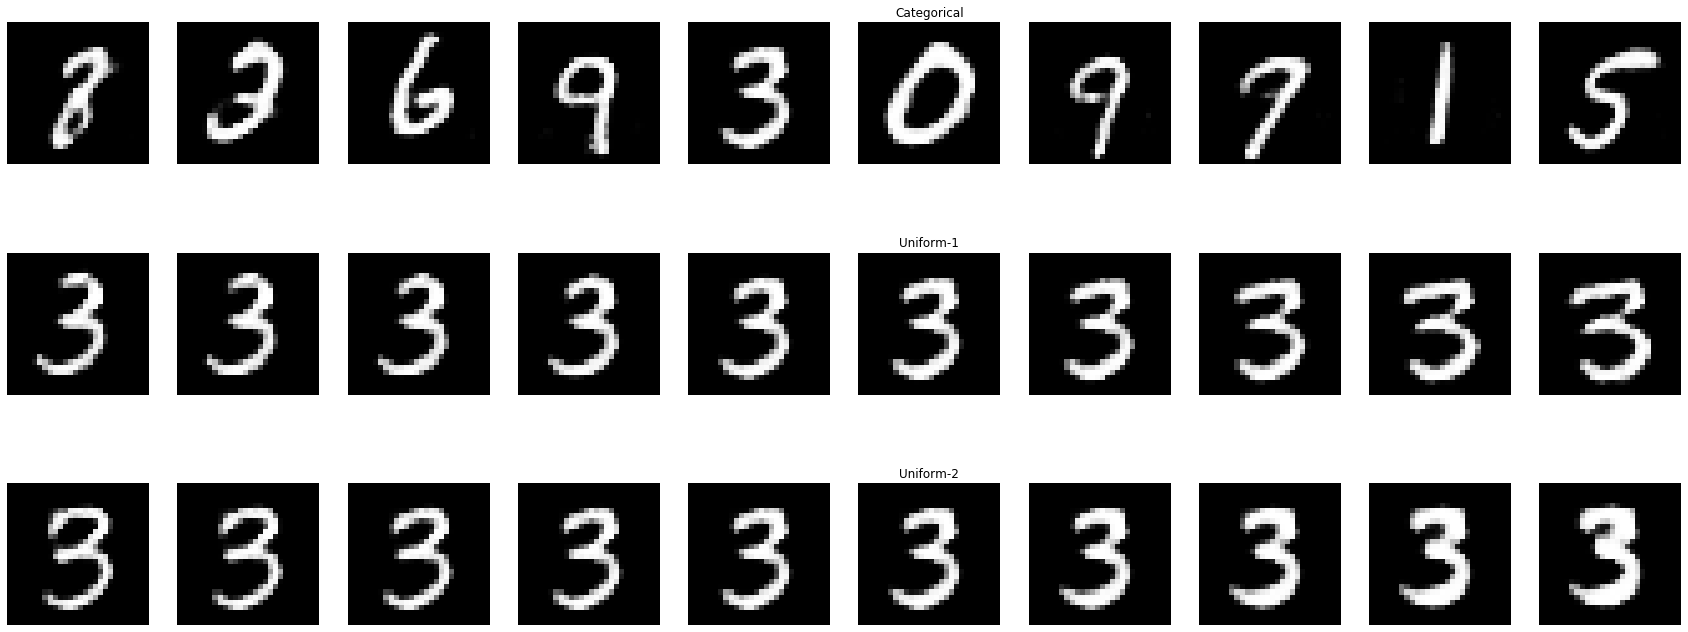

In [109]:
## -------- TRAVERSE CODE MNIST --------

data_name = "mnist"
model_name = "best_t"
cmap = "gray"
dir = "experiment/info-gan/" + data_name + "0"

## load model
generator, _ = load_info_gan(dir, data_name, model_name + ".pt", device)
generator.eval()

## load config
with open(dir + "/config.json") as f:
  config = json.load(f)

## fix the "noise" since we are only varying the code
num_of_variations = 10
latent_size = config["noise_dim"]
noise = torch.zeros(num_of_variations, latent_size)

## ----------------------------------
## codes variation
codes = []

#### varying categorical-distribution part
ccode = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device=device).unsqueeze(1)
ccode = to_flatten_categorical(ccode, 10, device)
ucode = torch.tensor([0., 0.], device=device).unsqueeze(0).repeat(num_of_variations, 1)
codes += [torch.cat([ccode, ucode], dim=-1)]

#### varying uniform-distribution part
ccode = torch.tensor([4] * num_of_variations, device=device).unsqueeze(1)
ccode = to_flatten_categorical(ccode, 10, device)
ucode_var = torch.tensor(np.linspace(-1, 1, 10), device=device, dtype=torch.float32).unsqueeze(1)
ucode_fix = torch.tensor([0.], device=device).unsqueeze(0).repeat(num_of_variations, 1)
codes += [torch.cat([ccode, ucode_var, ucode_fix], dim=-1)]
codes += [torch.cat([ccode, ucode_fix, ucode_var], dim=-1)]
## ----------------------------------

gen_imgs = []
for code in codes:
  ## generated image
  gen_img = generator(torch.cat([noise, code], dim=-1))
  gen_img = (gen_img + 1) / 2 ## from (-1, 1) due to tanh() to (0, 1)

  ## convert to renderable format and save
  if data_name == "mnist":
    gen_imgs.append(gen_img.squeeze(1).detach().cpu().numpy())
  elif data_name == "celeba":
    gen_imgs.append(gen_img.moveaxis(1, -1).detach().cpu().numpy())

## plot and save
filename = "figures/info_gan-" + data_name + "-" + model_name + "_model-interpolate_code.png"
plot_row_wise(gen_imgs, ["Categorical", "Uniform-1", "Uniform-2"], filename, cmap)

## Plot Reconstruction (Comparing VQ-VAE and Beta-VAE)

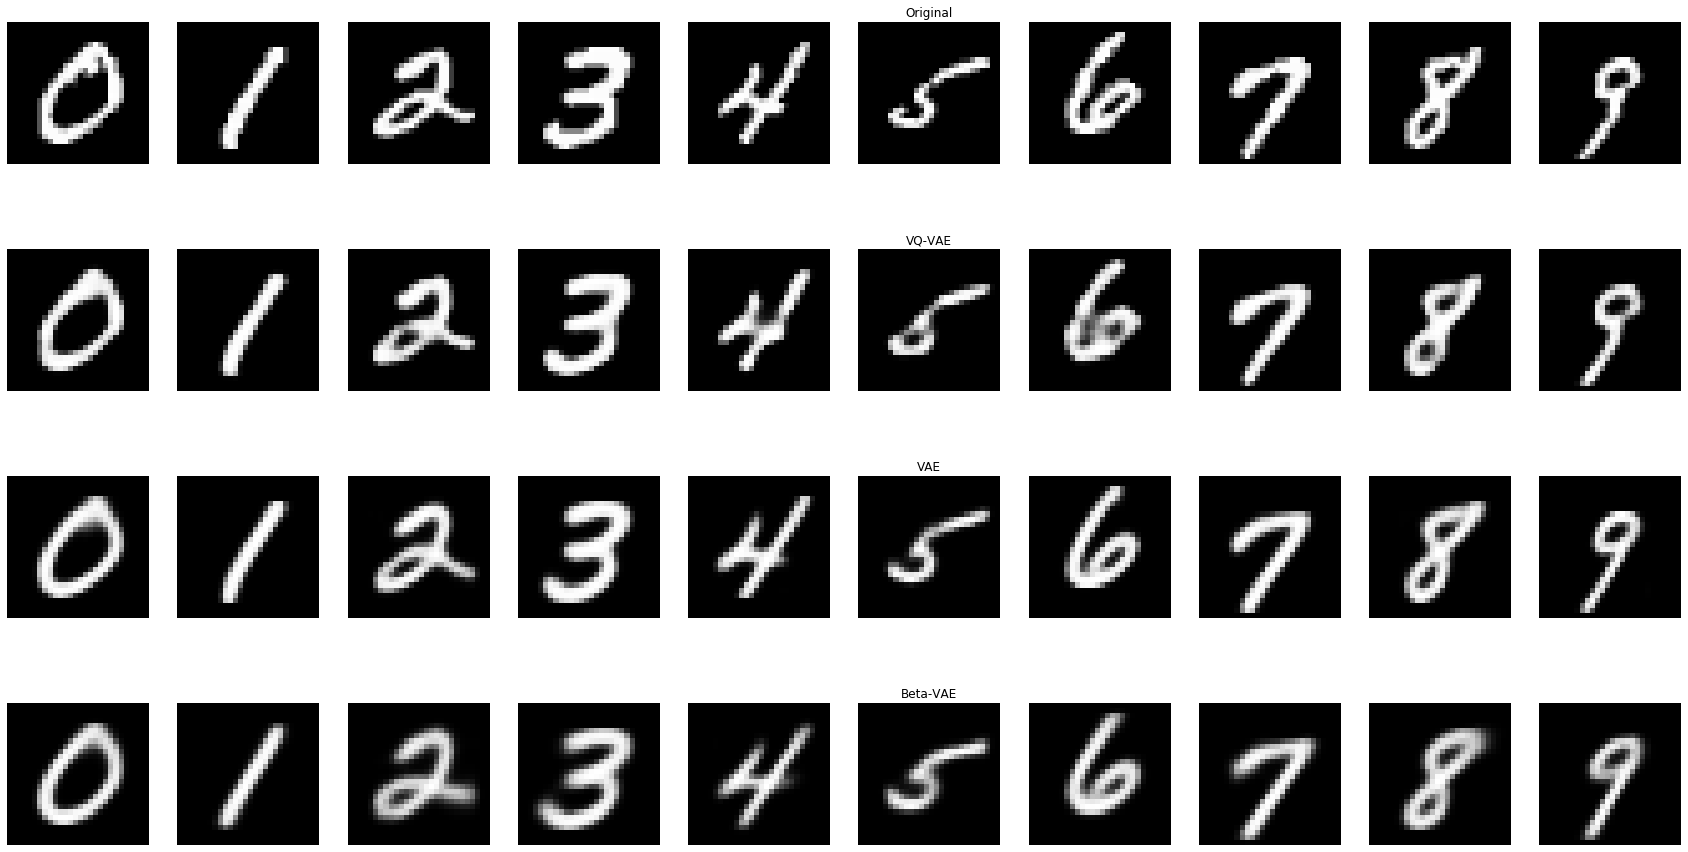

In [10]:
#############################
## -------- MNIST -------- ##
#############################

results, cmap, model_name = [], "gray", "latest"

## load MNIST data and carefully picked index
ds = load_dataset("mnist", is_data_train=True, is_prob_value=True)
idx = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

## prepare the image
imgs = torch.cat([ds[i][0].unsqueeze(0) for i in idx]).to(device)
results.append(imgs.squeeze(1).detach().cpu().numpy())

## -------- VQ-VAE --------

## load model
encoder, decoder, vqlayer = load_vq_vae("experiment/vq-vae/mnist0", model_name + ".pt", device)

## reconstruct input
ze = encoder(imgs)
zq, _ = vqlayer(ze)
recon_imgs = decoder(zq)

## convert to renderable format
recon_imgs = recon_imgs.squeeze(1).detach().cpu().numpy()
results.append(recon_imgs)

## -------- BETA-VAE --------

exp_dirs = ["experiment/beta-vae/mnist0", "experiment/beta-vae/mnist1"]
for dir in exp_dirs:
  ## load model
  model = load_beta_vae(dir, model_name + ".pt", device)

  ## reconstruct input
  var_posterior = model.encoder(imgs)
  recon_imgs = model.decoder(var_posterior.mean)

  ## convert to renderable format
  recon_imgs = recon_imgs.squeeze(1).detach().cpu().numpy()
  results.append(recon_imgs)

## -------- PLOT AND SAVE --------

filename = "figures/vq_vae-mnist-" + model_name + "_model-reconstruct-all.png"
plot_row_wise(results, ["Original", "VQ-VAE", "VAE", "Beta-VAE"], filename, cmap)

Files already downloaded and verified


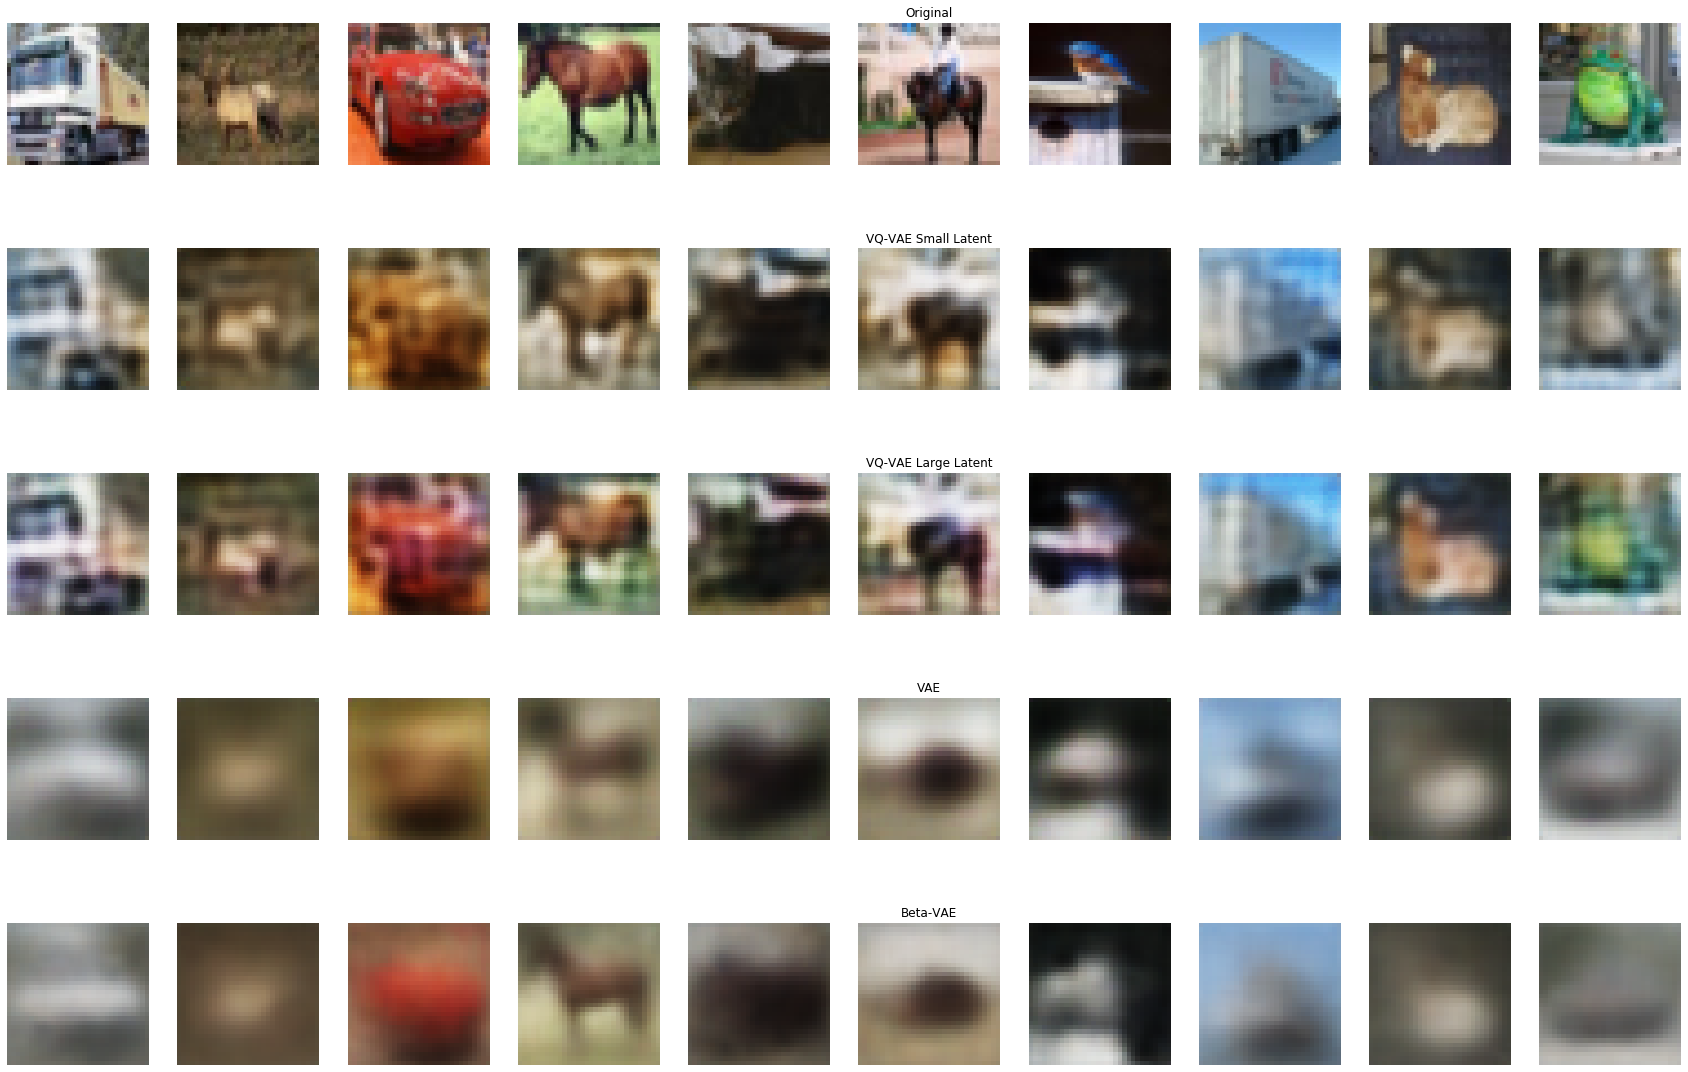

In [15]:
#############################
## ------- CIFAR10 ------- ##
#############################

results, cmap, model_name = [], None, "best"

## load MNIST data and carefully picked index
ds = load_dataset("cifar10", is_data_train=True, is_prob_value=True)
idx = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

## prepare the image
imgs = torch.cat([ds[i][0].unsqueeze(0) for i in idx]).to(device)
results.append(imgs.moveaxis(1, -1).detach().cpu().numpy())

## -------- VQ-VAE --------

exp_dirs = ["experiment/vq-vae/cifar100", "experiment/vq-vae/cifar101"]
for dir in exp_dirs:
  ## load model
  encoder, decoder, vqlayer = load_vq_vae(dir, model_name + ".pt", device)

  ## reconstruct input
  ze = encoder(imgs)
  zq, _ = vqlayer(ze)
  recon_imgs = decoder(zq)

  ## convert to renderable format
  recon_imgs = recon_imgs.moveaxis(1, -1).detach().cpu().numpy()
  results.append(recon_imgs)

## -------- BETA-VAE --------

exp_dirs = ["experiment/beta-vae/cifar100", "experiment/beta-vae/cifar101"]
for dir in exp_dirs:
  ## load model
  model = load_beta_vae(dir, model_name + ".pt", device)

  ## reconstruct input
  var_posterior = model.encoder(imgs)
  recon_imgs = model.decoder(var_posterior.mean)

  ## convert to renderable format
  recon_imgs = recon_imgs.moveaxis(1, -1).detach().cpu().numpy()
  results.append(recon_imgs)

## -------- PLOT AND SAVE --------

filename = "figures/vq_vae-cifar10-" + model_name + "_model-reconstruct-all.png"
plot_row_wise(results, ["Original", "VQ-VAE Small Latent", "VQ-VAE Large Latent", "VAE", "Beta-VAE"], filename, cmap)

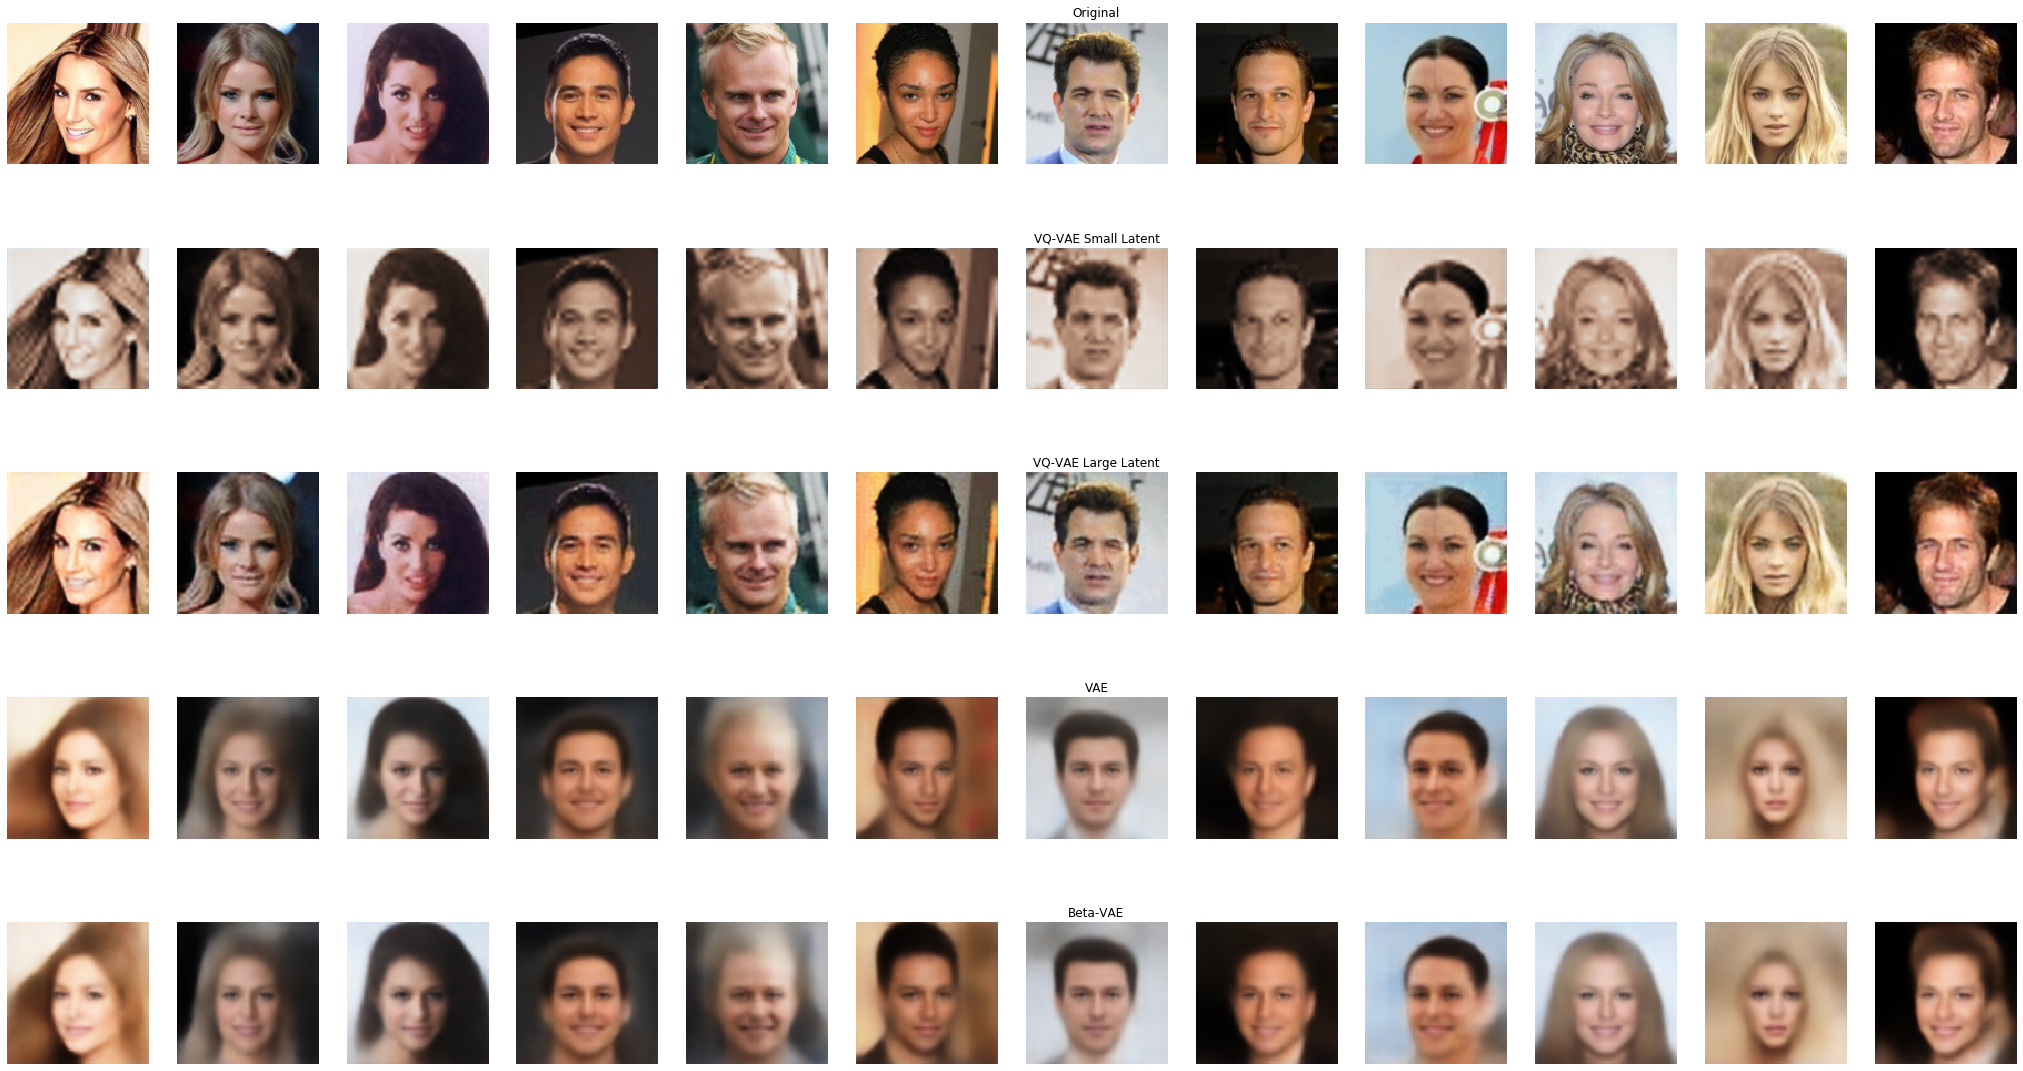

In [16]:
#############################
## ------- CIFAR10 ------- ##
#############################

results, cmap, model_name = [], None, "best"

## load MNIST data and carefully picked index
ds = load_dataset("celeba", is_data_train=True, is_prob_value=True)
idx = list(range(len(ds)))

## prepare the image
imgs = torch.cat([ds[i][0].unsqueeze(0) for i in idx]).to(device)
results.append(imgs.moveaxis(1, -1).detach().cpu().numpy())

## -------- VQ-VAE --------

exp_dirs = ["experiment/vq-vae/celeba0", "experiment/vq-vae/celeba1"]
for dir in exp_dirs:
  ## load model
  encoder, decoder, vqlayer = load_vq_vae(dir, model_name + ".pt", device)

  ## reconstruct input
  ze = encoder(imgs)
  zq, _ = vqlayer(ze)
  recon_imgs = decoder(zq)

  ## convert to renderable format
  recon_imgs = recon_imgs.moveaxis(1, -1).detach().cpu().numpy()
  results.append(recon_imgs)

## -------- BETA-VAE --------

exp_dirs = ["experiment/beta-vae/celeba0", "experiment/beta-vae/celeba1"]
for dir in exp_dirs:
  ## load model
  model = load_beta_vae(dir, model_name + ".pt", device)

  ## reconstruct input
  var_posterior = model.encoder(imgs)
  recon_imgs = model.decoder(var_posterior.mean)

  ## convert to renderable format
  recon_imgs = recon_imgs.moveaxis(1, -1).detach().cpu().numpy()
  results.append(recon_imgs)

## -------- PLOT AND SAVE --------

filename = "figures/vq_vae-celeba-" + model_name + "_model-reconstruct-all.png"
plot_row_wise(results, ["Original", "VQ-VAE Small Latent", "VQ-VAE Large Latent", "VAE", "Beta-VAE"], filename, cmap)

## Sampling from VQ-VAE

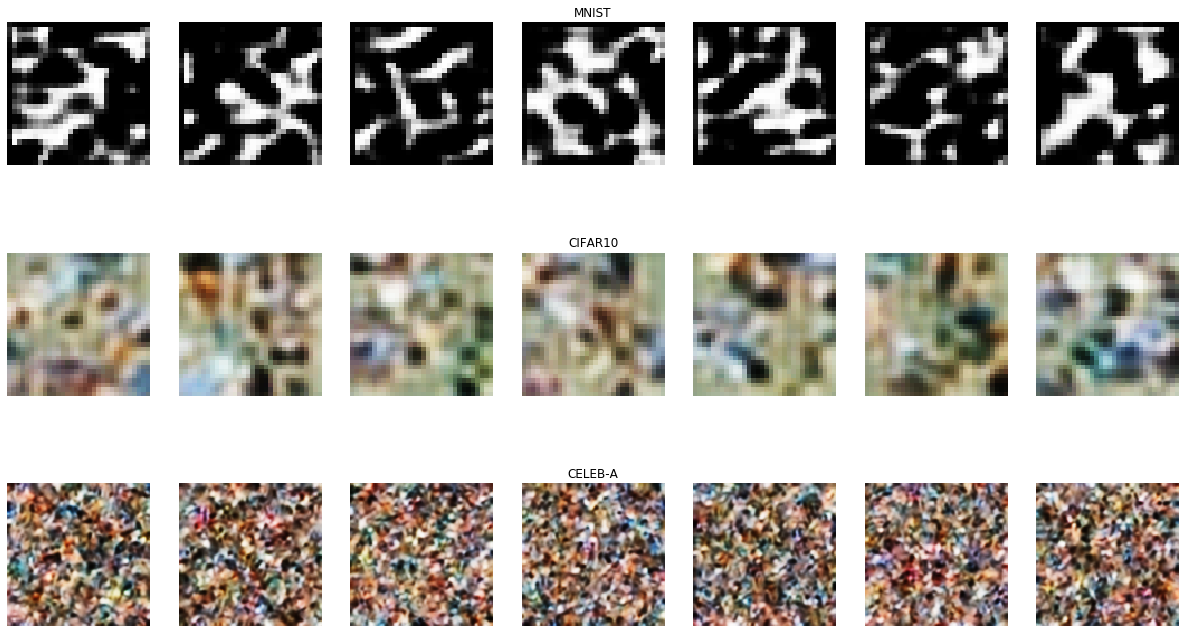

In [38]:
results, cmap, model_name = [], "gray", "latest"
results = []

exp_dirs = ["experiment/vq-vae/mnist0", "experiment/vq-vae/cifar101", "experiment/vq-vae/celeba1"]
for dir in exp_dirs:
  ## load model
  _, decoder, vqlayer = load_vq_vae(dir, model_name + ".pt", device)

  ## load config
  with open(dir + "/config.json") as f:
    config = json.load(f)

  num_samples = 7
  if "mnist" in dir: patch_size = (num_samples, 7, 7)
  elif "cifar10" in dir: patch_size = (num_samples, 8, 8)
  elif "celeba" in dir: patch_size = (num_samples, 32, 32)

  ## sample zq
  zq = torch.randint(0, config["num_embedding"], patch_size)
  zq = vqlayer.embedding(zq).moveaxis(3, 1)

  ## reconstruct
  recon_imgs = decoder(zq)

  ## convert to renderable format
  if "mnist" in dir:
    recon_imgs = recon_imgs.squeeze(1).detach().cpu().numpy()
  else:
    recon_imgs = recon_imgs.moveaxis(1, -1).detach().cpu().numpy()
  
  results.append(recon_imgs)

## plot and save
filename = "figures/vq_vae-mnist-" + model_name + "_model-sample.png"
plot_row_wise(results, ["MNIST", "CIFAR10", "CELEB-A"]*2, filename, cmap)